**NOTE:**
Connect to a High-RAM environment

**HRNet Implementation:** https://github.com/niecongchong/HRNet-keras-semantic-segmentation/blob/master/model/seg_hrnet.py

Import the libraries

In [1]:
from google.colab import drive
drive.mount('/gdrive')

import os
import cv2
import numpy as np
import tifffile as tiff
from sklearn.model_selection import train_test_split

Mounted at /gdrive


Load the dataset

In [2]:
def count_files(directory, extension=".tif"):
    # List all files in the directory and count those with the specified extension
    return sum(1 for file in os.listdir(directory) if file.endswith(extension))

# Paths to your image and mask directories
image_directory = '/gdrive/My Drive/Dataset/patches/train/images/'
mask_directory = '/gdrive/My Drive/Dataset/patches/train/masks/'

# Counting the TIFF files in both directories
image_count = count_files(image_directory)
mask_count = count_files(mask_directory)

print(f"Number of image files: {image_count}")
print(f"Number of mask files: {mask_count}")

Number of image files: 4787
Number of mask files: 4787


In [3]:
# Load the images and masks into the lists below
images = []
masks = []

# Sort filenames to ensure matching pairs align
image_files = sorted([f for f in os.listdir(image_directory) if f.endswith(".tif")])
mask_files = sorted([f for f in os.listdir(mask_directory) if f.endswith(".tif")])

# Determine how many files to load based on percentage
percentage_to_load = 20 / 100.0  # Set the % of dataset to be loaded here.
number_of_files_to_load = int(len(image_files) * percentage_to_load)

# Create a mapping of image names to their corresponding mask names by removing '_Buildings'
image_to_mask = {f: f.replace("_patch", "_Buildings_patch") for f in image_files}

# Only iterate over the subset of files determined by the percentage
print(f'Attempting to load {percentage_to_load*100}% of dataset: {number_of_files_to_load} images/mask pairs...')
for count, image_name in enumerate(image_files[:number_of_files_to_load], start=1):
    img_path = os.path.join(image_directory, image_name)
    mask_name = image_to_mask[image_name]
    mask_path = os.path.join(mask_directory, mask_name)

    if os.path.exists(mask_path):
        img = tiff.imread(img_path)
        mask = tiff.imread(mask_path)

        images.append(img)
        masks.append(mask)
    else:
        print(f'\nMask not found for image: {image_name}')

    # Update the count in the same line
    print(f'\rProcessed: {count}/{number_of_files_to_load}', end='')

print("\nLoading complete.")

# Convert the lists to numpy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

# Normalize the values
images /= 255.0
masks /= 255.0
masks = masks.reshape((-1, 256, 256, 1))

Attempting to load 20.0% of dataset: 957 images/mask pairs...
Processed: 957/957
Loading complete.


Perform Train/Test/Val Split

In [4]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=1995)

# Further split the training set into training and validation sets (90% train, 10% val)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1995)

# If there is an unnecessary singleton dimension in dataset, remove it:
if X_train.ndim > 3:  # Assuming the desired dimension is 3 (e.g., height x width x channels)
    X_train = X_train.squeeze(axis=1)
    X_val = X_val.squeeze(axis=1)
    X_test = X_test.squeeze(axis=1)

# Display the shapes of the datasets to confirm correct dimensions
print('Dataset Shapes:')
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_val:   {X_val.shape}, y_val: {y_val.shape}')
print(f'X_test:  {X_test.shape}, y_test: {y_test.shape}')

Dataset Shapes:
X_train: (688, 256, 256, 3), y_train: (688, 256, 256, 1)
X_val:   (77, 256, 256, 3), y_val: (77, 256, 256, 1)
X_test:  (192, 256, 256, 3), y_test: (192, 256, 256, 1)


Define the model

In [5]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, add, concatenate
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.backend import epsilon
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K

def stem_net(input):
    # Start with a convolution with stride 1 to maintain resolution
    x = Conv2D(64, 3, strides=(1, 1), padding='same', use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    # Reduced stride in the next layers or adjust according to your network depth need
    x = Conv2D(64, 3, strides=(1, 1), padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    return x

def transition_layer1(x, out_filters_list=[32, 64]):
    # Branch maintaining the current resolution
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    # Branch with reduced resolution
    x1 = Conv2D(out_filters_list[1], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    return [x0, x1]

def make_branch1_0(x, out_filters=32):
    # Applying multiple basic blocks to process high-resolution features
    x = basic_Block(x, out_filters, with_conv_shortcut=True)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x

def make_branch1_1(x, out_filters=64):
    # Processing slightly lower resolution features
    x = basic_Block(x, out_filters, with_conv_shortcut=True)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x

def fuse_layer1(x):
    # x is a list of feature maps from different branches
    x0_0 = x[0]  # High-resolution feature map
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)  # Upsampling to match high-res dimensions
    x0 = add([x0_0, x0_1])  # Adding features from different resolutions

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]  # Lower resolution features
    x1 = add([x1_0, x1_1])  # Combining features with downsampling high-res features

    return [x0, x1]

def transition_layer2(x, out_filters_list=[32, 64, 128]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    return [x0, x1, x2]

def make_branch2_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x

def make_branch2_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x

def make_branch2_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x

def fuse_layer2(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0 = add([x0_0, x0_1, x0_2])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1_2 = Conv2D(64, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x1_2 = BatchNormalization(axis=3)(x1_2)
    x1_2 = UpSampling2D(size=(2, 2))(x1_2)
    x1 = add([x1_0, x1_1, x1_2])

    x2_0 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_0 = Activation('relu')(x2_0)
    x2_0 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x2_0)
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_1 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2_1 = BatchNormalization(axis=3)(x2_1)
    x2_2 = x[2]
    x2 = add([x2_0, x2_1, x2_2])

    return [x0, x1, x2]

def final_layer(x, classes=1):
    # Removing the sigmoid activation to use logits
    x = Conv2D(classes, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    # No activation layer here
    return x

def seg_hrnet(input_shape=(256, 256, 3), classes=1):
    inputs = Input(shape=input_shape)

    # Stem network
    x = stem_net(inputs)

    # Transition Layer 1
    x = transition_layer1(x)
    x0 = make_branch1_0(x[0])
    x1 = make_branch1_1(x[1])
    x = fuse_layer1([x0, x1])

    # Transition Layer 2
    x = transition_layer2(x)
    x0 = make_branch2_0(x[0])
    x1 = make_branch2_1(x[1])
    x2 = make_branch2_2(x[2])
    x = fuse_layer2([x0, x1, x2])

    # Final Layer
    out = final_layer(x[0], classes=classes)

    model = Model(inputs=inputs, outputs=out)
    return model

# CUSTOM METRICS
def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]) > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + K.epsilon())

def jaccard_index(y_true, y_pred, threshold=0.5):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]) > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

# LOSS FUNCTION
def calculate_class_weights(masks):
    # Flatten the mask array to get a 1D array of labels
    flat_labels = masks.flatten().astype(int)

    # Calculate the class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(flat_labels), y=flat_labels)

    # Create a dictionary to map class labels to weights
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    return class_weights_dict

def weighted_binary_crossentropy(weights):
    def loss(y_true, y_pred):
        # Calculate the binary cross-entropy loss
        bce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weighted_bce = bce * (weights[1] * y_true + weights[0] * (1 - y_true))

        return K.mean(weighted_bce)

    return loss

# MODEL FEATURES
def basic_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    x = conv3x3(input, out_filters, strides)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = conv3x3(x, out_filters)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x

def conv3x3(x, out_filters, strides=(1, 1)):
    x = Conv2D(out_filters, 3, padding='same', strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
    return x

Compile the model

In [8]:
from tensorflow.keras.optimizers import Adam

# Calculate the class weights for the training masks
class_weights = calculate_class_weights(y_train)
print("Class weights:", class_weights)
weighted_loss = weighted_binary_crossentropy(class_weights)

model = seg_hrnet()
model._name = 'HRNet_class_weights_20'
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=weighted_loss,
    metrics=['accuracy', dice_coefficient, jaccard_index, sensitivity, specificity, precision]
)

model.summary()

Class weights: {0: 0.533457059946358, 1: 7.972264460799221}
Model: "HRNet_class_weights_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_59 (Conv2D)          (None, 256, 256, 64)         1728      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_59 (Ba  (None, 256, 256, 64)         256       ['conv2d_59[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_48 (A

Train

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Setup early stopping to monitor the 'val_loss' and stop training after 10 epochs of no improvements
early_stopping = EarlyStopping(
    monitor='val_dice_coefficient',
    patience=10,
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Setup model checkpointing to save the best model observed during training for later use
model_checkpoint = ModelCheckpoint(
    '/gdrive/My Drive/Dataset/Models/best_hrnet_class_weights_20',  # Path where the model will be saved
    monitor='val_dice_coefficient',  # Save the model based on the maximum dice_coefficient value
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Fit the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

# Save the model
model.save('/gdrive/My Drive/Dataset/Models/hrnet_class_weights_20.h5')
model.save('/gdrive/My Drive/Dataset/Models/hrnet_class_weights_20')

Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 4.1163 - accuracy: 0.7435 - dice_coefficient: 0.1757 - jaccard_index: 0.0966 - sensitivity: 0.4472 - specificity: 0.7643 - precision: 0.1103 
Epoch 1: val_dice_coefficient improved from -inf to 0.11721, saving model to /gdrive/My Drive/Dataset/Models/best_hrnet_class_weights_20
22/22 [==============================] - 694s 31s/step - loss: 4.1163 - accuracy: 0.7435 - dice_coefficient: 0.1757 - jaccard_index: 0.0966 - sensitivity: 0.4472 - specificity: 0.7643 - precision: 0.1103 - val_loss: 7.0000 - val_accuracy: 0.1078 - val_dice_coefficient: 0.1172 - val_jaccard_index: 0.0624 - val_sensitivity: 0.9834 - val_specificity: 0.0530 - val_precision: 0.0624
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 3.2674 - accuracy: 0.7679 - dice_coefficient: 0.2213 - jaccard_index: 0.1247 - sensitivity: 0.5284 - specificity: 0.7843 - precision: 0.1408 
Epoch 2: val_dice_coefficient improved from 0.11721 to 0.16934

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluate

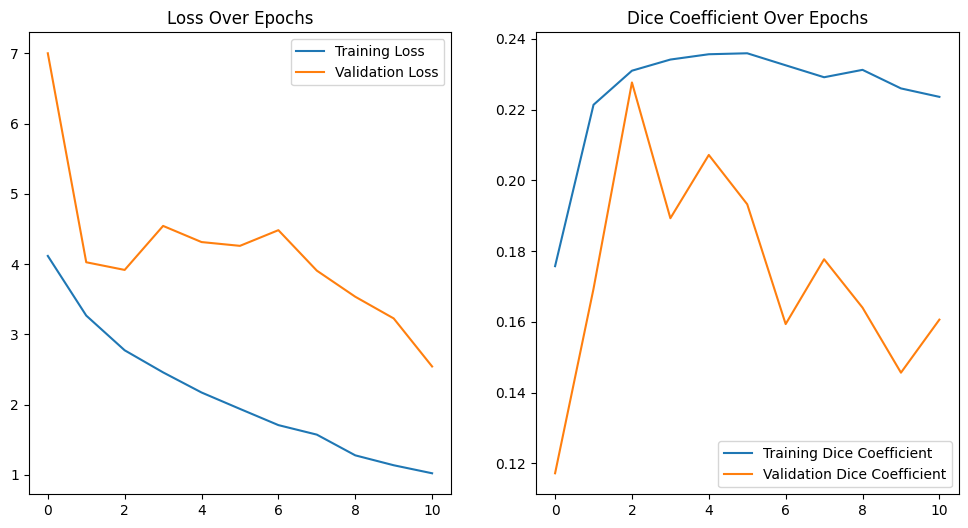

6/6 [==============================] - 42s 7s/step


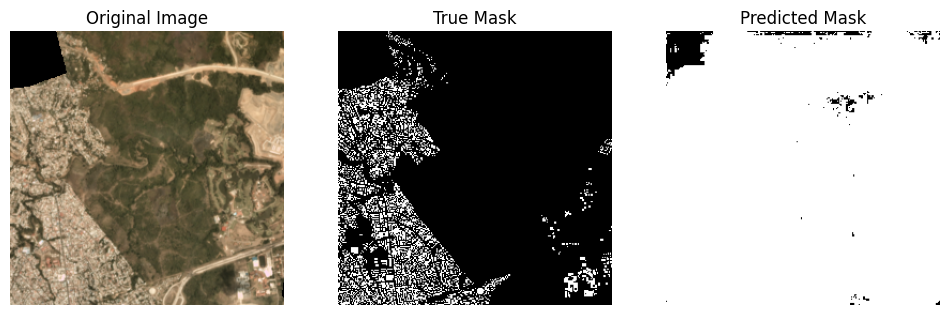

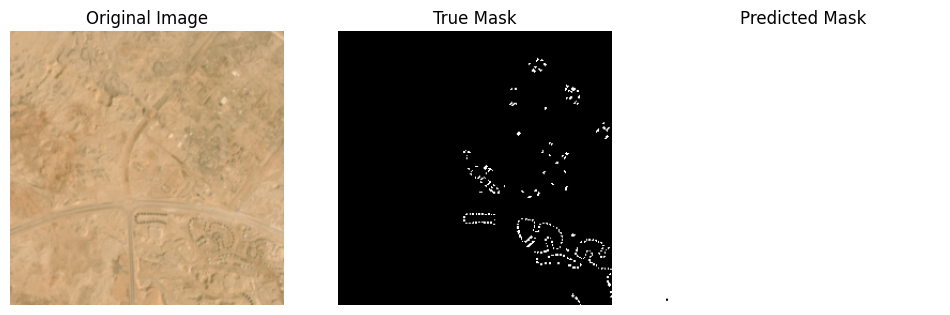

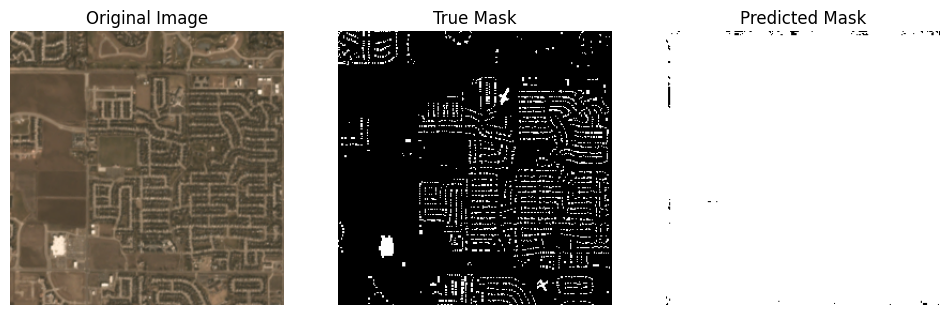

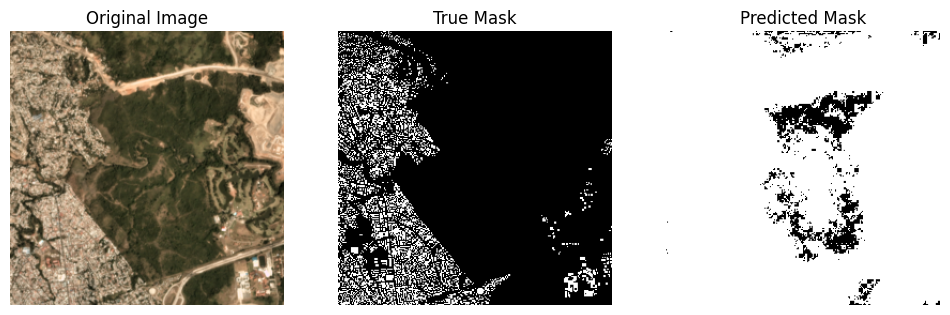

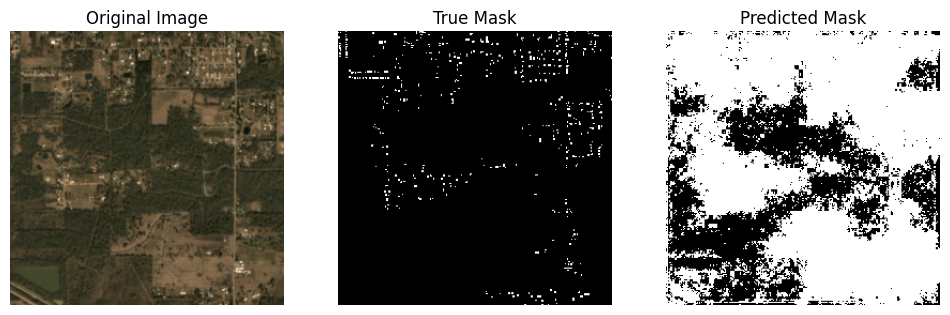

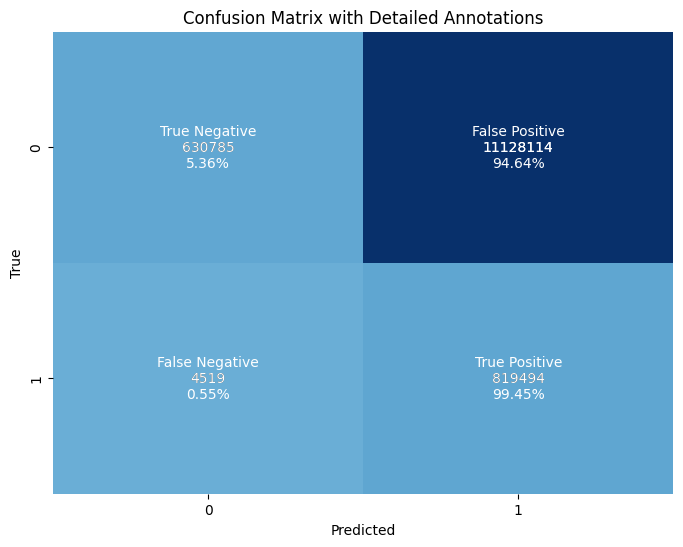

              precision    recall  f1-score   support

         0.0       0.99      0.05      0.10  11758899
         1.0       0.07      0.99      0.13    824013

    accuracy                           0.12  12582912
   macro avg       0.53      0.52      0.12  12582912
weighted avg       0.93      0.12      0.10  12582912



In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.title('Dice Coefficient Over Epochs')
    plt.legend()

    plt.show()

def show_predictions(X, y_true, y_pred, num_samples=5):
    indices = np.random.choice(range(len(X)), num_samples, replace=False)

    for i in indices:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(X[i])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(y_pred[i].squeeze() > 0.5, cmap='gray')  # Apply a threshold to convert probabilities to binary mask
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

def plot_confusion_matrix(y_true, y_pred):
    # Flattening the masks
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(int)  # Thresholding probabilities

    cm = confusion_matrix(y_true_f, y_pred_f)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Adding labels for each quadrant
    labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cm_normalized.flatten()]

    # Position labels in the center of each quadrant
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(labels, counts, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, center=0)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix with Detailed Annotations')
    plt.show()


# Perform the evaluation
plot_training_history(history)
y_pred = model.predict(X_test)
show_predictions(X_test, y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test.flatten(), (y_pred.flatten() > 0.5).astype(int)))